In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pickle
import os

from tqdm import tqdm
from abc import ABC, abstractmethod

cuda_enabled = False
to_gpu = lambda x: x.cuda() if cuda_enabled else x

%matplotlib inline 

In [2]:
#methods to calculate norms and inner products for lists of tensors

def norm_sq(v):
  return torch.sum(torch.stack([torch.norm(vi)**2 for vi in v]))

def inner_prod(v, w): #is there a better way to do this?
  return torch.sum(torch.stack([ torch.dot(torch.flatten(v_i), torch.flatten(w_i)) 
              for v_i,w_i in zip(v,w)]))

def classification_accuracy(data_loader, model):
  total=0
  correct=0
  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = to_gpu(images), to_gpu(labels)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()

  return correct/total

#Assumes that all batches have same size (fix?)
def total_loss(data_loader, model, loss_fn):
  total = 0
  count = 0
  with torch.no_grad():
    for x,y in data_loader:
      x,y = to_gpu(x), to_gpu(y)
      pred = model(x)
      loss = loss_fn(pred,y)
      total += loss #FIX THIS
      count += 1
  return total/count

In [3]:
class Trainer(ABC):

  def __init__(self, model, criterion, trainloader, testloader):
    self.model = model
    self.criterion = criterion
    self.trainloader = trainloader
    self.testloader = testloader

    self.batch_losses = []
    self.test_class_accs = [] #classification accuracy on test data
    self.train_class_accs = [] #classification accuracy on training data
    self.total_train_losses = [] #Loss over the entire training set
    self.total_test_losses = [] #Loss over the entire testing set

    self.loss = None
    self.suppress_data = False
  
  @abstractmethod
  def do_step():
    pass

  def only_batch_data(self, flag=True):
    self.suppress_data = flag

  def update_logs(self):
    if not self.suppress_data:
      self.test_class_accs.append(classification_accuracy(self.testloader, self.model))
      self.train_class_accs.append(classification_accuracy(self.trainloader, self.model))
      self.total_train_losses.append(total_loss(self.trainloader, self.model, self.criterion))
      self.total_test_losses.append(total_loss(self.testloader,self.model, self.criterion))
      
  def train(self, n_epochs):
    for epoch in range(n_epochs):

      print("Epoch: ", epoch)
      self.update_logs()

      for x, y in tqdm(self.trainloader):
          x, y = to_gpu(x), to_gpu(y)
          pred = self.model(x)
          self.loss = self.criterion(pred,y)
          self.batch_losses.append(self.loss.item())
          self.do_step()

    self.update_logs()

class StandardTrainer(Trainer):
  def __init__(self, model, criterion, trainloader, testloader, optimizer):
    super().__init__(model, criterion, trainloader, testloader)
    self.optimizer = optimizer

  def do_step(self):
    self.loss.backward()
    self.optimizer.step()
    self.optimizer.zero_grad()

class Sps2Base(Trainer):

  def __init__(self, model, criterion, trainloader, testloader, beta):
    super().__init__(model, criterion, trainloader, testloader)

    zero_fill = [torch.zeros_like(w_i) for w_i in self.model.parameters()]
    self.last_two_steps = [zero_fill, zero_fill] #most recent step, followed by the previous step
    self.beta = beta


  @abstractmethod
  def get_step(self):
    pass

  def update_momentum(self, step):
    self.last_two_steps[0], self.last_two_steps[1] = step, self.last_two_steps[0]

  def get_momentum(self):
    return [self.beta * (a-b) for a,b in zip(self.last_two_steps[0], self.last_two_steps[1])]

  
  def do_step(self):
    step = self.get_step()
    with torch.no_grad():
        for w_i, step_i in zip(self.model.parameters(), step):
            w_i.sub_(step_i)

'''
Original trainer without momentum
class Sps2Trainer(Sps2Base):

  def get_step(self):
      f = self.loss
      grad_f = torch.autograd.grad(f, self.model.parameters(), create_graph=True)
      hessian_grad = torch.autograd.grad(grad_f, self.model.parameters(), grad_outputs = grad_f) #should work, but worth checking

      a = f/norm_sq(grad_f)
      B = [grad_f_i - a * hessian_grad_i for grad_f_i,hessian_grad_i in zip(grad_f, hessian_grad)]
      hessgrad_grad = inner_prod(hessian_grad, grad_f)
      norm_sq_B = norm_sq(B)
      step = [a*grad_f_i + 0.5 * (a**2) * hessgrad_grad * B_i/norm_sq_B for grad_f_i,B_i in zip(grad_f, B)] #compute step separately for each layer

      return step
'''

class Sps2Trainer(Sps2Base):

  def get_step(self):
      f = self.loss
      grad_f = torch.autograd.grad(f, self.model.parameters(), create_graph=True)
      hessian_grad = torch.autograd.grad(grad_f, self.model.parameters(), grad_outputs = grad_f) #should work, but worth checking

      with torch.no_grad():
        a = f/norm_sq(grad_f)
        B = [grad_f_i - a * hessian_grad_i for grad_f_i,hessian_grad_i in zip(grad_f, hessian_grad)]
        hessgrad_grad = inner_prod(hessian_grad, grad_f)
        norm_sq_B = norm_sq(B)
        step = [a*grad_f_i + 0.5 * (a**2) * hessgrad_grad * B_i/norm_sq_B for grad_f_i,B_i in zip(grad_f, B)] #compute step separately for each layer

        self.update_momentum(step)

        inertia_term = self.get_momentum() #add on the momentum term
        for step_i, m_i in zip(step, inertia_term):
          step_i.add_(m_i)

        return step


plus = lambda x: x if x>0 else 0
'''def plus(x):
  return x if x >= 0 else 0
'''

class Sps2SlackTrainer(Sps2Base):

  def __init__(self, model, criterion, trainloader, testloader, lmbda, init_s, beta):
    super().__init__(model, criterion, trainloader, testloader, beta)
    self.lmbda = lmbda
    self.s = init_s

  def get_step(self):
    f = self.loss
    lmbda = self.lmbda
    s_t = self.s

    grad_f = torch.autograd.grad(f, self.model.parameters(), create_graph=True)
    hessian_grad = torch.autograd.grad(grad_f, self.model.parameters(), grad_outputs = grad_f) #should work, but worth checking

    norm_sq_grad_f = norm_sq(grad_f)
    Gamma_1 = plus(f - (1 - lmbda)*s_t) / (1-lmbda + norm_sq_grad_f)

    Gamma_2_signed_numerator = f - Gamma_1*norm_sq_grad_f \
      + 0.5*(Gamma_1**2)*inner_prod(hessian_grad, grad_f) \
      - ((1-lmbda)**2) * (s_t + Gamma_1)

    A = [grad_f_i - Gamma_1*hessian_grad_i 
        for grad_f_i, hessian_grad_i in zip(grad_f, hessian_grad)] #comes up twice, so only compute once

    Gamma_2_denom =  1 - lmbda + norm_sq(A)
    Gamma_2 = plus(Gamma_2_signed_numerator)/Gamma_2_denom

    step = [Gamma_1 * grad_f_i + Gamma_2 * A_i for grad_f_i, A_i in zip(grad_f, A)]
    new_s = (1-lmbda)*((1-lmbda)*(s_t + Gamma_1) + Gamma_2)

    
    self.update_momentum(step)

    inertia_term = self.get_momentum() #add on the momentum term
    for step_i, m_i in zip(step, inertia_term):
        step_i.add_(m_i)
    
    self.s = new_s
    return step

In [4]:
def load_MNIST(batch_size=50):
  transform_train = transforms.Compose([
    transforms.ToTensor()
    ,transforms.Normalize((0.1307,), (0.3081,))
  ])
  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
  ])

  train_data = torchvision.datasets.MNIST(root="./", train=True,download=True, transform=transform_train)
  test_data = torchvision.datasets.MNIST(root="./", train=False,download=True, transform=transform_test)


  trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  testloader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False)

  return trainloader, testloader

---

# **Models**

In [10]:
class Small_Model(nn.Module):
    def __init__(self):
        super(Small_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 5)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        #self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(144, 10)

    def forward(self, x):
        y = self.pool(self.relu(self.conv1(x)))
        #y = self.pool(self.relu(self.conv2(y)))
        y = y.view(y.shape[0], -1)
        y = self.relu(self.fc1(y))
        return y

class Medium_Model(nn.Module):
    def __init__(self):
        super(Medium_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        y = self.pool(self.relu(self.conv1(x)))
        y = self.pool(self.relu(self.conv2(y)))
        y = y.view(y.shape[0], -1)
        y = self.relu(self.fc1(y))
        y = self.relu(self.fc2(y))
        y = self.fc3(y)
        return y

class Large_Model(nn.Module):
    def __init__(self):
        super(Large_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        y = self.pool(self.relu(self.conv1(x)))
        y = self.pool(self.relu(self.conv2(y)))

        y = y.view(y.shape[0], -1)
        y = self.relu(self.fc1(y))
        y = self.relu(self.fc2(y))
        y = self.fc3(y)
        return y

In [11]:
def num_trainable_params(model):
  return np.sum( [np.prod(p.size()) for p in model.parameters()])

In [12]:
print("Small params: ", num_trainable_params(Small_Model()))
print("Medium params: ", num_trainable_params(Medium_Model()))
print("Large params: ", num_trainable_params(Large_Model()))

Small params:  1476
Medium params:  44426
Large params:  331594


<b> Experiments </b>

In [13]:
def save_data_as(trainer, name, info):
    
    path = './experiments/' + name
    try:
        os.mkdir(path)
    except: #folder already exists
        pass
    
    items = [trainer.batch_losses, trainer.test_class_accs, trainer.train_class_accs,
            trainer.total_train_losses, trainer.total_test_losses, trainer.model]
    filenames = ["batch_losses", "test_class_accs", "train_class_accs",
            "total_train_losses", "total_test_losses", "model"]
    for item, filename in zip(items, filenames):
        pickle.dump( item, open( path + "/" + filename + ".pkl", "wb" ) )
    
    with open(path + "/info.txt", "w") as info_file:
        info_file.write(info)

        
def load_data(name, return_model=False):
    path = './experiments/' + name
    filenames = ["batch_losses", "test_class_accs", "train_class_accs",
                "total_train_losses", "total_test_losses"]
    
    data = {}
    for filename in filenames:
        data[filename] = pickle.load( open( path + "/" + filename + ".pkl", "rb" ) )
    
    if return_model:
        model = pickle.load( open( path + "/" + "model" + ".pkl", "rb" ) )
        return data, model
    else:
        return data

def run_and_save_MNIST(exp_name, opt_method, model_size, n_epochs, method_kwargs, batch_size=50, rand_seed=0):
    
    torch.manual_seed(rand_seed)

    if model_size == "small":
        model = to_gpu(Small_Model())
    elif model_size == "medium":
        model = to_gpu(Medium_Model())
    elif model_size == "large":
        model = to_gpu(Large_Model())
    else:
        assert(False)
        
    trainloader, testloader = load_MNIST(batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    
    if opt_method == "sps2":
        trainer = Sps2Trainer(model, criterion, trainloader, testloader, **method_kwargs)
    elif opt_method == "sps2slack":
        trainer = Sps2SlackTrainer(model, criterion, trainloader, testloader, **method_kwargs)
    else:
        assert(False)
        
    trainer.train(n_epochs)
    
    info = "data: MNIST" + \
        "\nmethod: " + opt_method + \
        "\nmodel size: " + model_size + \
        "\nepochs: " + str(n_epochs) + \
        "\nbatch size: " + str(batch_size) + \
        "\nargs: " + str(method_kwargs) + \
        "\nseed: " + str(rand_seed)
    
    save_data_as(trainer, exp_name, info)

<b> Run Experiments </b>

In [14]:
exp_name = "sps2test"
opt_method = "sps2"
method_kwargs = {'beta': 0.01}
model_size = "large"
n_epochs = 2
batch_size = 50
rand_seed = 0

run_and_save_MNIST(exp_name, opt_method, model_size, n_epochs, method_kwargs, batch_size=batch_size, rand_seed=rand_seed)

Epoch:  0


100%|██████████| 1200/1200 [02:21<00:00,  8.46it/s]


Epoch:  1


100%|██████████| 1200/1200 [02:25<00:00,  8.24it/s]


In [ ]:
exp_name = "sps2slacktest"
opt_method = "sps2slack"
method_kwargs = {'lmbda':0.5, 'init_s':1, 'beta':0.01}
model_size = "medium"
n_epochs = 2
batch_size = 50
rand_seed = 0

run_and_save_MNIST(exp_name, opt_method, model_size, n_epochs, method_kwargs, batch_size=batch_size, rand_seed=rand_seed)

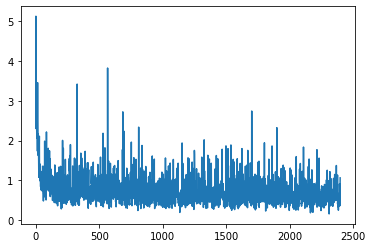

In [118]:
data = load_data("sps2slacktest")
plt.plot(data['batch_losses'][0:])

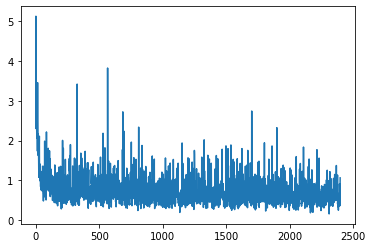

In [120]:
data = load_data("sps2slacktest")
plt.plot(data['batch_losses'][0:])

<b> Junk </b>

In [ ]:
'''
torch.manual_seed(0)
train_model = small_model #generate the model with random weights

criterion = nn.CrossEntropyLoss()
n_epochs = 5

#trainer = Sps2Trainer(train_model, criterion, trainloader, testloader)

trainer = Sps2SlackTrainer(train_model, criterion, trainloader, testloader,lmbda=0.5, init_s=1, beta=0.01)

#trainer = Sps2MomentumTrainer(train_model, criterion, trainloader, testloader, beta=0.01)

#optimizer = torch.optim.Adam(train_model.parameters(), lr=0.001)
#trainer = StandardTrainer(train_model, criterion, trainloader, testloader, optimizer = optimizer)

trainer.only_batch_data(False) #get all the data
trainer.train(n_epochs)
'''